In [1]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models import resnet50, ResNet50_Weights
from deep_sort_realtime.deepsort_tracker import DeepSort

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
import sys
from pathlib import Path

# Get the path to the project root directory
project_root = Path.cwd().parents[0]

# Add the project root to sys.path
sys.path.append(str(project_root))

In [4]:
# COCO class names
COCO_CLASSES = [
    "__background__", "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
    "truck", "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "couch", "potted plant", "bed", "dining table", "toilet", "TV", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]

# COCO class names
COCO_CLASSES_target_ = [
    "__background__", "person", "bicycle", "car", "motorcycle", "bus", "truck"
]

COCO_CLASSES_target = {class_name: COCO_CLASSES.index(class_name) for class_name in COCO_CLASSES_target_}
COCO_CLASSES_target

{'__background__': 0,
 'person': 1,
 'bicycle': 2,
 'car': 3,
 'motorcycle': 4,
 'bus': 6,
 'truck': 8}

In [5]:
# Load Faster R-CNN model
model = fasterrcnn_resnet50_fpn(
    weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,
    progress=True,
    weights_backbone=ResNet50_Weights.DEFAULT
)

model.eval()  # Set the model to evaluation mode
model = model.to(device)

In [6]:
from src.detection.ObjectDetector import ObjectDetector 
from src.tracking.SingleClassTracker import SingleClassTracker
from src.tracking.MultiClassTracker import MultiClassTracker  
  
from src.processor.VideoDetectionTracker import VideoDetectionTracker

from src.utils.LineCounter import LineCounter
from src.utils.LineDrawer import LineDrawer
from src.utils.ObjectDetectionVisualizer import ObjectDetectionVisualizer

In [7]:
class Config:
    model = model
    max_age = 3                      # max_age: Maximum number of frames to keep track of lost objects 
    tracker_name = "deepsort"        # Tracker Name to associate detections with existing objects
    classes=COCO_CLASSES_target
    confidence_threshold=0.6         # Minimum confidence score to keep detections
    nms_threshold=0.5                # IoU threshold for Non-Maximum Suppression   
    resize=None                    # Tuple (min_size, max_size) for resizing frames while maintaining aspect ratio. #(600, 800) #None
    device=device
    fps = None                       # Desired frames per second or None to keep original frames in the output video 
    frame_skip = 2                   # Process every frame (set to >1 to skip frames), None to keep
    video_path = '../data/Video2.mp4'
    output_path = "../output/output_video_2.mp4" 

In [8]:
# line config
drawer = LineDrawer(Config.video_path, resize=Config.resize)
lines_config = drawer.run()
print("Line configurations:")
for line in lines_config:
    print(line)

Click to define points for lines (two clicks per line). Press 'q' to quit.
Line configurations:
{'start_point': (139, 642), 'end_point': (355, 489), 'name': 'Line1', 'color': (0, 0, 255)}
{'start_point': (405, 501), 'end_point': (569, 537), 'name': 'Line2', 'color': (255, 0, 0)}
{'start_point': (712, 561), 'end_point': (860, 592), 'name': 'Line3', 'color': (255, 0, 255)}


### Initialize

In [9]:
# Initialize the Detector
detector = ObjectDetector(
    model=Config.model,
    classes=Config.classes,
    device=Config.device,
    confidence_threshold=Config.confidence_threshold,  
    nms_threshold=Config.nms_threshold,                    
    resize=Config.resize
)

In [10]:
# Initialize multi-class tracker
multi_tracker = MultiClassTracker(
    detector=detector,
    tracker_name=Config.tracker_name,
    max_age=Config.max_age,
    line_counter=LineCounter(lines_config),
    target_classes=['person', 'car', 'bus', 'motorcycle', 'truck']  # Optional custom class Tracker selection    # ['person', 'car', 'bus', 'motorcycle']
)

/home/hellraiser/.local/lib/python3.12/site-packages/deep_sort_realtime/embedder/embedder_pytorch.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_

In [11]:
# Initialize single-class tracker
single_tracker = SingleClassTracker(
    detector=detector,
    tracker_name=Config.tracker_name,
    max_age=Config.max_age,
    target_class= 'car', #'bicycle' #'car'
    line_counter=LineCounter(lines_config)
)


In [12]:
# Initialize the VideoProcessor
video_processor = VideoDetectionTracker(
    detector=detector,
    tracker_option=multi_tracker, 
    confidence_threshold=Config.confidence_threshold,                   
    resize=Config.resize
)

In [13]:
# Run Video Detector Tracking
video_processor.process_video(
    video_path=Config.video_path,
    output_path=Config.output_path, 
    frame_skip=Config.frame_skip,
    fps=Config.fps
)

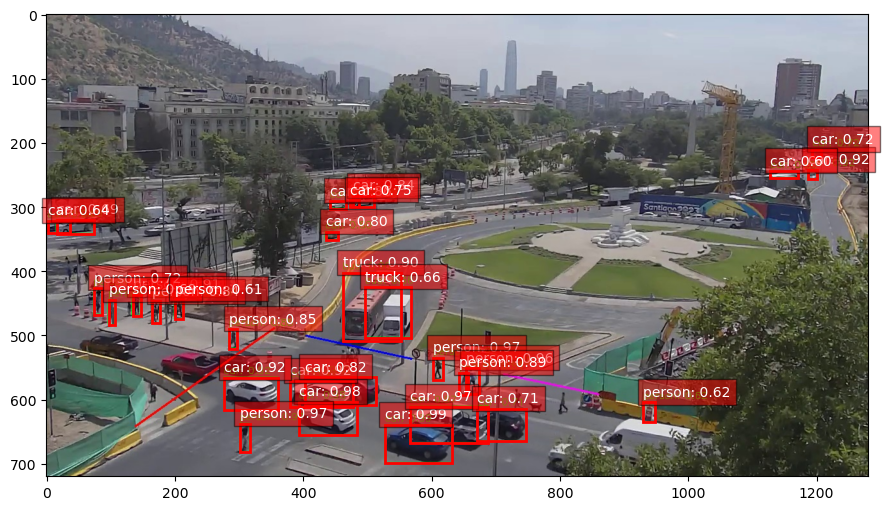

In [14]:
# Usage
visualizer = ObjectDetectionVisualizer(threshold=0.6)
image_path = 'frame.jpg'
image, boxes, labels, scores = detector.detect(image_path) 
visualizer.plot_with_plt(image, boxes, labels, scores, COCO_CLASSES_target_)